<a href="https://colab.research.google.com/github/navi004/Deep-Learning-CSE4037-/blob/main/ViT_Pneumonia_Detection_DA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection Using Vision Transformer (ViT) Fine-Tuned on Chest X-Ray Images - Digital Assignment 3
####  Model Used: google/vit-base-patch16-224-in21k
####  Dataset: Chest X-Ray Images (Normal vs Pneumonia)

- Name : Naveen N
- Reg No: 22MIA1049


## Setting Kaggle Api

In [1]:
from google.colab import files
files.upload()  # upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"naveenn004","key":"5ac65378a95863be100585b9533df14d"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:

import kagglehub
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

print('Data source import complete.')


Data source import complete.


In [4]:
# Setup: Install Kaggle API for direct dataset download

!kaggle datasets download paultimothymooney/chest-xray-pneumonia

# Unzip the dataset and remove the zip file
!unzip chest-xray-pneumonia.zip && rm chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

##Import Necessary Libraries

In [5]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [6]:
!nvcc --version  # CUDA version
!python -c "import torch; print(torch.__version__)"  # PyTorch version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
2.6.0+cu124


In [11]:
pip install -q evaluate transformers datasets mlflow

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

import tensorflow as tf
from transformers import ViTFeatureExtractor, TFAutoModelForImageClassification
from sklearn.model_selection import train_test_split


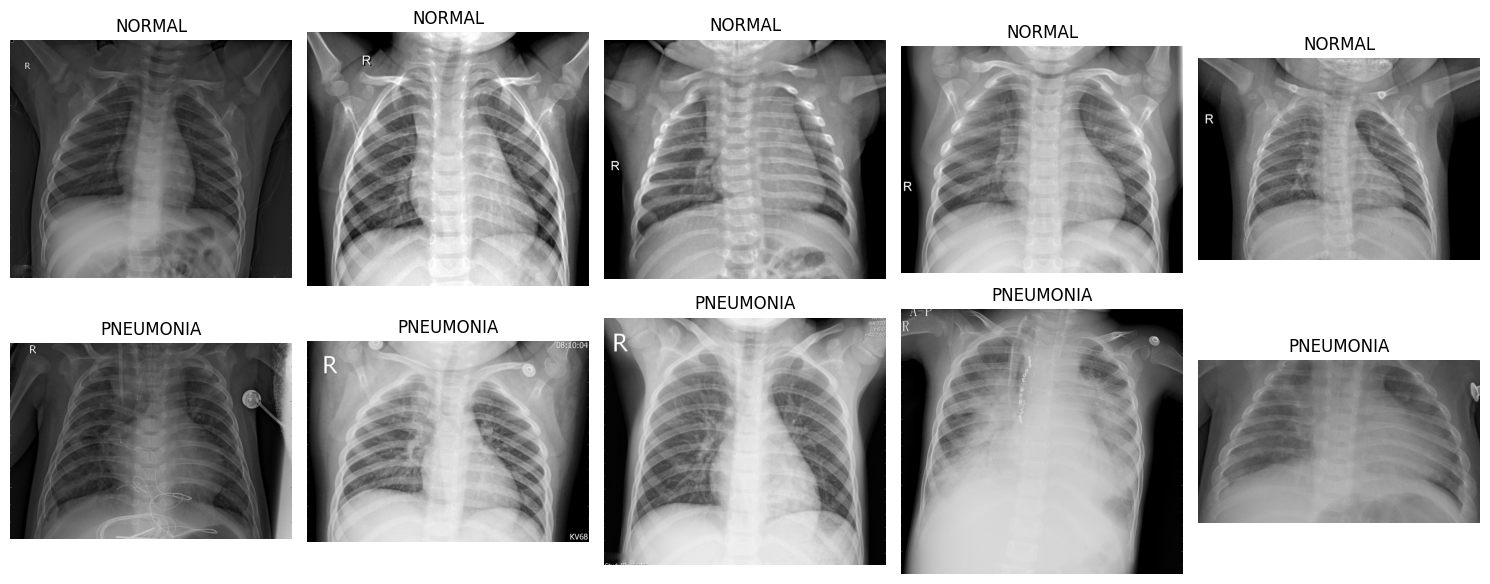

In [9]:
# Directory paths
train_dir = Path("/kaggle/input/chest-xray-pneumonia/chest_xray/train")
val_dir = Path("/kaggle/input/chest-xray-pneumonia/chest_xray/val")
test_dir = Path("/kaggle/input/chest-xray-pneumonia/chest_xray/test")

# Displaying a few images
def display_images(folder, num=5):
    pneumonia_imgs = list(folder.glob('PNEUMONIA/*.jpeg'))[:num]
    normal_imgs = list(folder.glob('NORMAL/*.jpeg'))[:num]

    fig, axes = plt.subplots(nrows=2, ncols=num, figsize=(15, 6))

    for i, img_path in enumerate(normal_imgs):
        img = Image.open(img_path)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title("NORMAL")
        axes[0, i].axis('off')

    for i, img_path in enumerate(pneumonia_imgs):
        img = Image.open(img_path)
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].set_title("PNEUMONIA")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

display_images(train_dir)


## Data Exploration

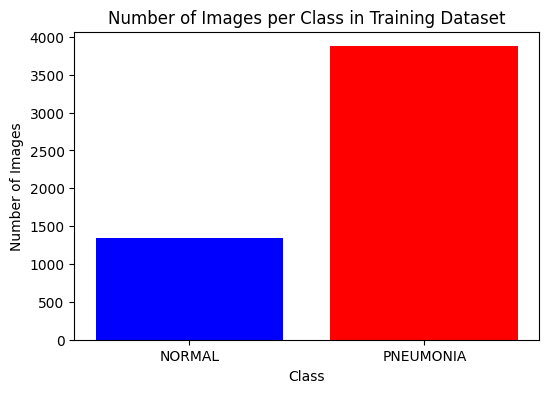

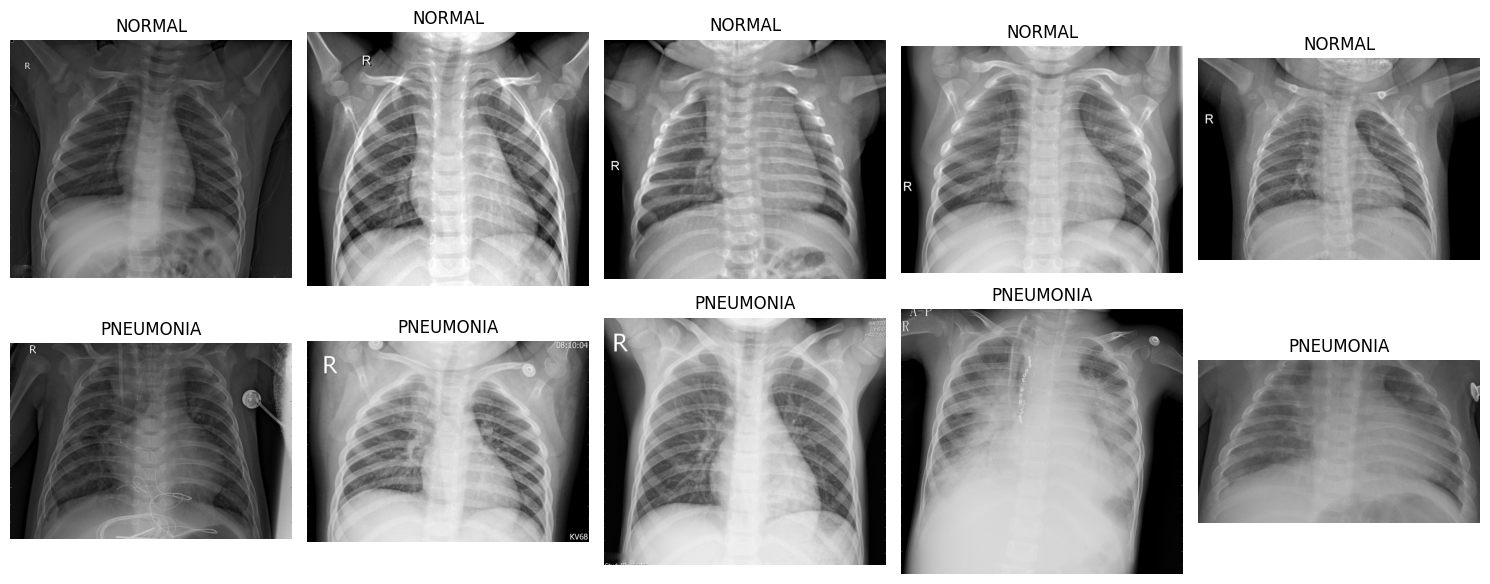

In [10]:
# 1. Dataset Exploration (Count images, plot bar chart, sample images)
normal_count = len(list(train_dir.glob('NORMAL/*.jpeg')))
pneumonia_count = len(list(train_dir.glob('PNEUMONIA/*.jpeg')))

# Plotting the bar chart
classes = ['NORMAL', 'PNEUMONIA']
counts = [normal_count, pneumonia_count]

plt.figure(figsize=(6, 4))
plt.bar(classes, counts, color=['blue', 'red'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class in Training Dataset')
plt.show()

# Display sample images from the dataset
display_images(train_dir)

## Data Preprocessing

We'll define transformations for the images to make them suitable for input into the ViT model.


In [12]:
from torchvision import transforms

# Define transformations for the training, validation, and testing sets
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


In [13]:
label_mapping = {"NORMAL": 0, "PNEUMONIA": 1}


## Creating Data Loaders

Data loaders provide an efficient way to iterate through the dataset in batches.


In [14]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Creating datasets
train_dataset = ImageFolder(train_dir, transform=train_transforms)
val_dataset = ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = ImageFolder(test_dir, transform=val_test_transforms)

# Creating data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## Setting Up the Vision Transformer (ViT) Model

We'll be using the ViT model pre-trained on a large dataset and fine-tuning it on our chest X-ray dataset.


In [15]:
from transformers import ViTForImageClassification, ViTConfig, ViTImageProcessor

# Load the pre-trained config and set number of labels
config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")
config.num_labels = 2  # For binary classification (NORMAL and PNEUMONIA)

# Load the pre-trained model with the updated config
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    config=config,
    ignore_mismatched_sizes=True  # Optional: avoids head mismatch errors
)

# Load the image processor (for preprocessing)
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

## Define Loss and Optimizer

We'll use the CrossEntropy loss as it's suitable for binary classification tasks. For optimization, we'll use the Adam optimizer.


In [16]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)


## Model Training

Let's train the ViT model on our chest X-ray dataset. We'll also validate the model on the validation set after each epoch.


In [17]:
import torch
import torch.nn as nn
from tqdm import tqdm  # To show progress bar

# Check for GPU availability and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the training function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    # Move model to device (GPU or CPU)
    model.to(device)

    train_losses = []  # List to store training loss for each epoch
    val_accuracies = []  # List to store validation accuracy for each epoch

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Training phase
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Training)", leave=False):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images).logits  # Get logits from model outputs
            loss = criterion(outputs, labels)

            # Backpropagation
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)", leave=False):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculating average loss and accuracy
        avg_train_loss = running_loss / len(train_loader.dataset)
        val_accuracy = 100 * correct / total

        # Append the computed values to their respective lists
        train_losses.append(avg_train_loss)
        val_accuracies.append(val_accuracy)

        # Print training loss and validation accuracy
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    return model, train_losses, val_accuracies


In [18]:
trained_model, train_losses, val_accuracies = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10)


Epoch 1/10, Loss: 0.2223, Validation Accuracy: 93.75%


Epoch 2/10, Loss: 0.0794, Validation Accuracy: 93.75%


Epoch 3/10, Loss: 0.0620, Validation Accuracy: 75.00%


Epoch 4/10, Loss: 0.0494, Validation Accuracy: 93.75%


Epoch 5/10, Loss: 0.0408, Validation Accuracy: 93.75%


Epoch 6/10, Loss: 0.0370, Validation Accuracy: 62.50%


Epoch 7/10, Loss: 0.0286, Validation Accuracy: 87.50%


Epoch 8/10, Loss: 0.0311, Validation Accuracy: 93.75%


Epoch 9/10, Loss: 0.0227, Validation Accuracy: 93.75%


Epoch 10/10, Loss: 0.0188, Validation Accuracy: 81.25%


## Model Evaluation

Let's evaluate the trained ViT model on the test dataset.


In [19]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

evaluate_model(trained_model, test_loader)


Test Accuracy: 77.72%


## Save the Model

After training, it's essential to save the model weights to avoid retraining in the future.


In [20]:
# Save the model weights
torch.save(trained_model.state_dict(), "vit_chest_xray_model.pth")


## Visualization of Sample Data

Displaying a few images from both NORMAL and PNEUMONIA classes to get a feel for the data.


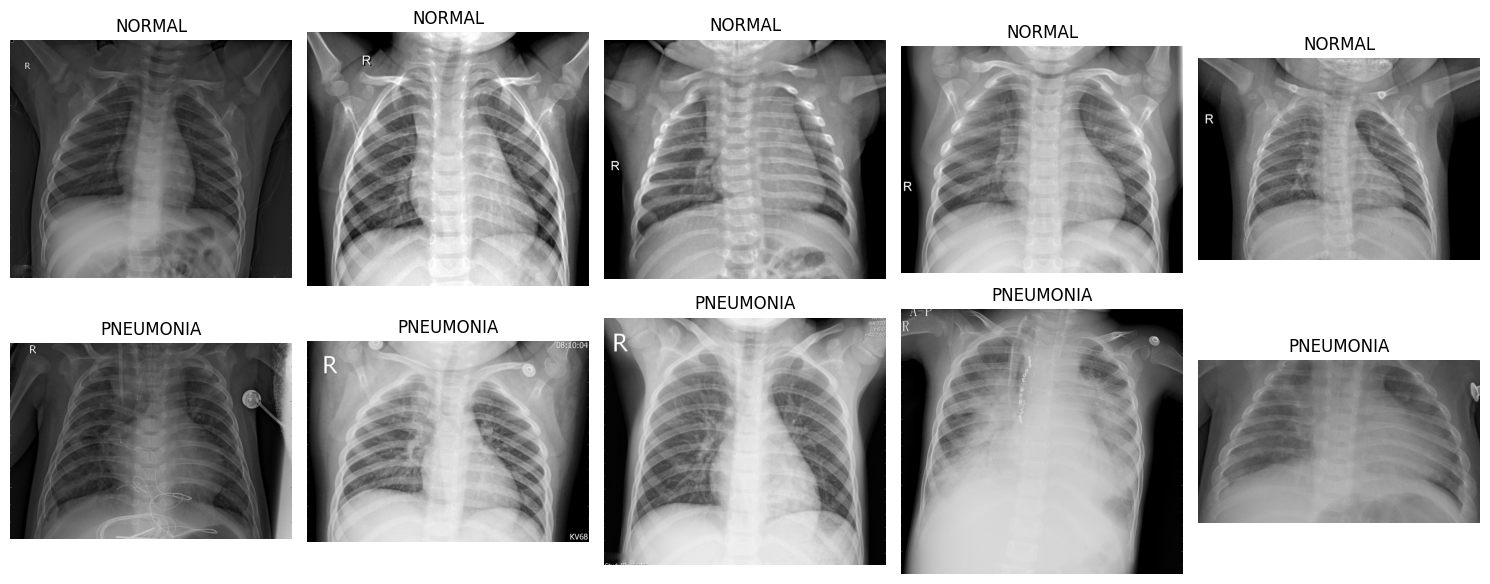

In [21]:
display_images(train_dir)


In [22]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()

        # Training Phase
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation Phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).logits
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    return model, train_losses, val_accuracies


## Training and Validation Metrics Visualization

Plotting the training loss and validation accuracy to understand the model's learning progress.


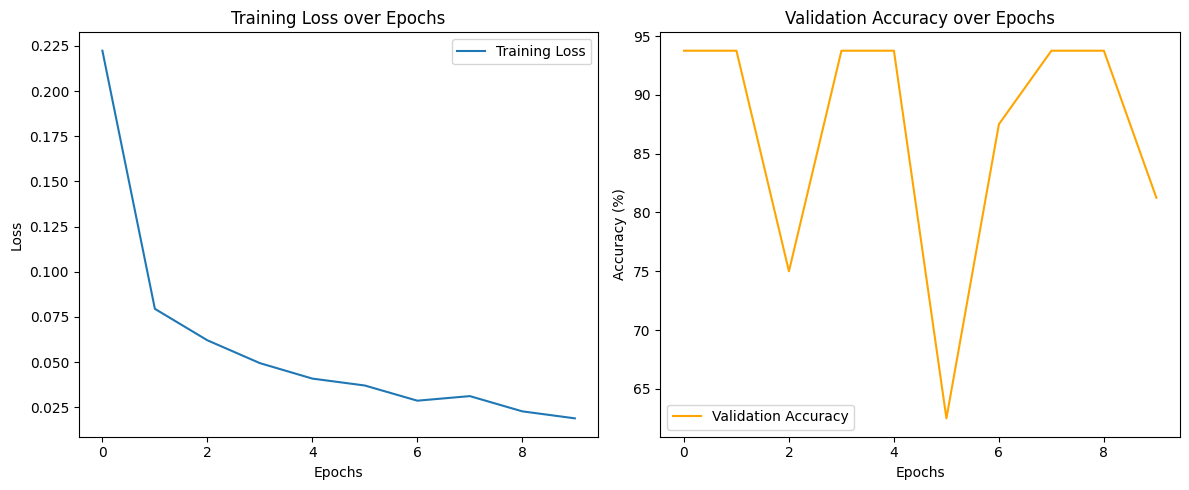

In [23]:
plt.figure(figsize=(12, 5))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


From the above graphs, we observe that the training loss decreased over time, which is a positive sign. The validation accuracy remains high, suggesting that the model generalizes well. The dip in accuracy around the second epoch followed by consistent high accuracy indicates that the model might have overcome some initial adaptation challenges but then consistently performed well.

## Confusion Matrix

Visualizing the model's predictions using a confusion matrix to understand its performance in more detail.


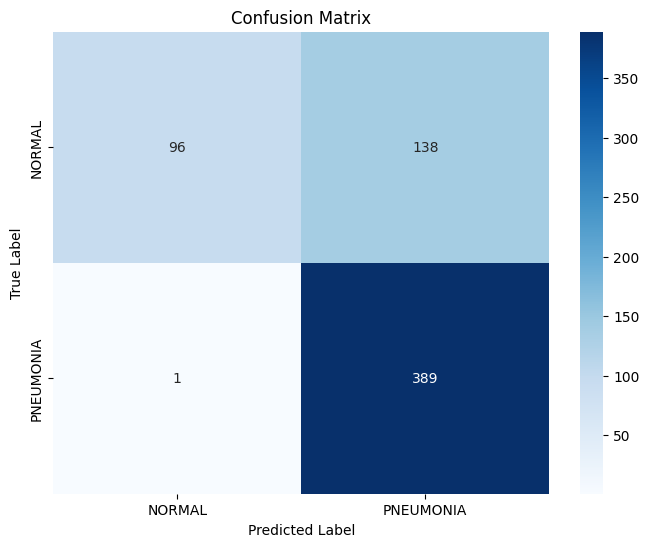

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Getting the true labels and the predicted labels
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Now, we'll plot the confusion matrix
labels_list = ["NORMAL", "PNEUMONIA"]
plot_confusion_matrix(y_true, y_pred, labels_list)


## Classification Report

In [25]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels_list))


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.99      0.41      0.58       234
   PNEUMONIA       0.74      1.00      0.85       390

    accuracy                           0.78       624
   macro avg       0.86      0.70      0.71       624
weighted avg       0.83      0.78      0.75       624



## AUC & ROC Curve

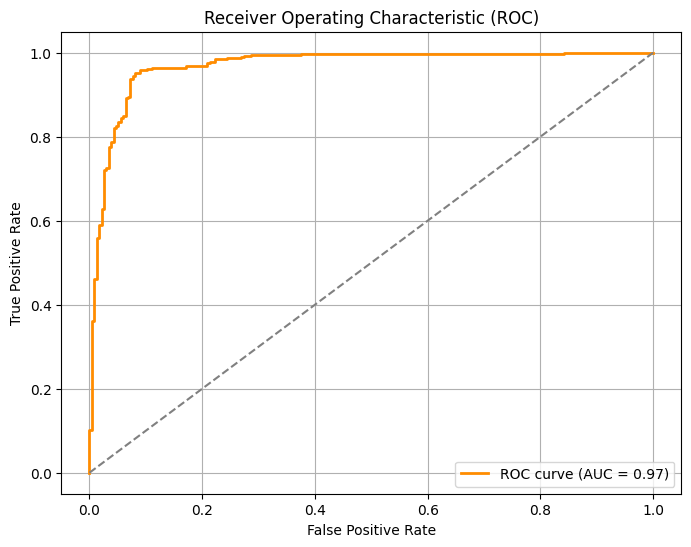

In [27]:
from sklearn.metrics import roc_curve, auc

# Get prediction probabilities for the positive class (PNEUMONIA)
model.eval()
y_probs = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images).logits
        probs = torch.softmax(outputs, dim=1)
        y_probs.extend(probs[:, 1].cpu().numpy())  # class index 1 = PNEUMONIA

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.grid()
plt.show()
